In [56]:
import numpy as np
from spline import Spline
import math
from scipy import optimize
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint

In [57]:
FOV_range = 10
scale_resolution = .1
x_ = np.arange(0, FOV_range*2, scale_resolution)
y_ = np.arange(0, FOV_range*2, scale_resolution)
x0 = 9.99
y0 = 0
sigx = 1
sigy = 1
Xg, Yg = np.meshgrid(x_, y_)
SiP = [0, 4]
obj = 2
probability_threshold = 0.01
numbers_of_ctrl_points = 20

In [58]:
def gauss_function_2d(x, x0, y0, sigma_x, sigma_y):
    '''Calculate the values of an unrotated Gauss function given positions
    in x and y in a mesh grid'''
    A = (1. / (2 * np.pi*sigma_x*sigma_y))
    return A*np.exp(-(x[0]-x0)**2/(2*sigma_x**2) -(x[1]-y0)**2/(2*sigma_y**2))

In [59]:
def object_function(x, goalPosition=(20,20)):
    '''Calculate the difference between the goal position and the current
    position of the distance'''
    res = math.dist((x[-2], x[-1]), goalPosition)
    # print(res)
    return res

In [60]:
s = (0, 0) #startpoint

In [61]:
def con_cltr_pnt(x):
    con = []
    con.append(math.dist((s[0], s[1]), (x[0], x[1])))
    for i in range(0, len(x)-2, 2):
        con.append(math.dist((x[i], x[i+1]), (x[i+2], x[i+3])))
    # print(len(con))
    return con

nlc = NonlinearConstraint(con_cltr_pnt, 0.0, 1.0)

In [62]:
def inturder_linear_path(start, stop, num):
    '''Calculate the linear path between two points'''
    x = np.linspace(start[0], stop[0], num)
    y = np.linspace(start[1], stop[1], num)
    return x, y

In [63]:
local = inturder_linear_path([0,15], [16,10], numbers_of_ctrl_points)
inturder_list = []
inturder_list.append(local)
local = inturder_linear_path([20,5], [0,10], numbers_of_ctrl_points)
inturder_list.append(local)
local = inturder_linear_path([2.5,0], [20,17.5], numbers_of_ctrl_points)
inturder_list.append(local)
# inturder_list = np.array(inturder_list).T
# print(inturder_list)
# print(inturder_list[1][0][1])
# print(len(inturder_list))
# print(len(inturder_list[0][1]))

In [64]:
def obj_crete(x):
    tmp = []

    for i in range(0, len(x), 2):
        out = 0
        for j in range(len(inturder_list)):
            # print(i, j)
            gau = gauss_function_2d([x[i], x[i+1]], inturder_list[j][0][int(i/2)], inturder_list[j][1][int(i/2)], 1.05**(i/2), 1.05**(i/2))
            out = out + gau
        tmp.append(out)
        # print(out)
    return tmp

P_nlc = NonlinearConstraint(obj_crete, 0.0, probability_threshold)

In [65]:
int_X0 = np.zeros(numbers_of_ctrl_points*2)
# print(int_X0)
res = minimize(object_function, int_X0, method='SLSQP', bounds=[(-0, 20) for i in range(len(int_X0))], constraints=[nlc, P_nlc])
print(res.success)
print(res.message)

True
Optimization terminated successfully


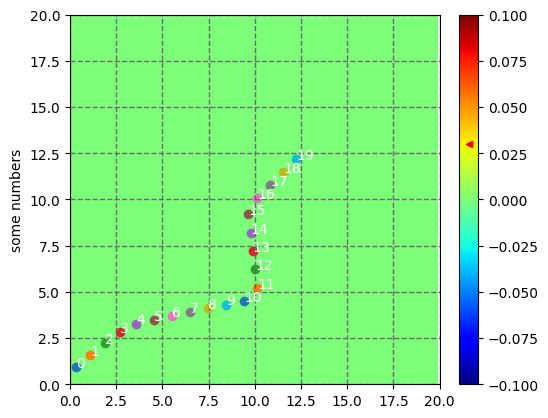

In [66]:
G = gauss_function_2d([Xg, Yg], x0, y0, sigx, sigy)
G = np.zeros_like(G)
fig = figure()
ax = fig.add_subplot(1,1,1)
box = (x_.min(), x_.max(), y_.min(), y_.max())          # left, right, bottom, top
im = ax.imshow(G, interpolation="none", origin='lower', extent=box, cmap='jet') #, vmin = 0, vmax = 0.15
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.scatter(0.0, 0.03, s=20, c='r', marker="<")
# ax.scatter(x0, y0, marker='x', color='silver', s=50)
ax.grid(color='dimgrey', linestyle='--', linewidth=1)
plt.ylabel('some numbers')
plt.axis([0, FOV_range*2, 0, FOV_range*2])
for i in range(0, len(res.x), 2):
    plt.scatter(res.x[i], res.x[i+1])
    ax.annotate(int(i/2), (res.x[i], res.x[i+1]), color='w')
plt.show()

40
0


AttributeError: 'FigureCanvasAgg' object has no attribute 'buffer_rgb'

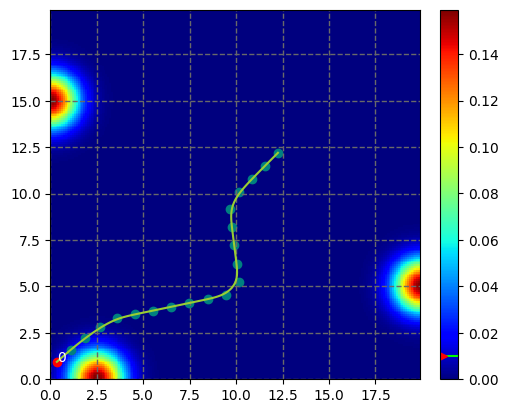

In [95]:
from geomdl import BSpline
from geomdl import utilities
from geomdl.visualization import VisMPL
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg


# Create a B-Spline curve
curve = BSpline.Curve()
# Set up the curve
curve.degree = 4
frames = []
print(len(res.x))

for j in range(0, len(res.x), 2):
    cp = []
    print(j)
    G = 0
    out = 0
    for i in range(0, len(inturder_list)):
        G_tmp = gauss_function_2d([Xg, Yg], inturder_list[i][0][int(j/2)], inturder_list[i][1][int(j/2)], 1.05**(j/2), 1.05**(j/2))
        G = G + G_tmp
        
        gau = gauss_function_2d([res.x[j], res.x[j+1]], inturder_list[i][0][int(j/2)], inturder_list[i][1][int(j/2)], 1.05**(j/2), 1.05**(j/2))
        out = out + gau

    fig = figure()
    ax = fig.add_subplot(1,1,1)
    box = (x_.min(), x_.max(), y_.min(), y_.max())          # left, right, bottom, top
    im = ax.imshow(G, interpolation="none", origin='lower', extent=box, cmap='jet') #, vmin = 0, vmax = 0.15
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # draw a circle as a pointer on the colorbar's axes at value 0.5
    cbar.ax.scatter(0.0, out, s=1000, c='lime', marker="_")
    cbar.ax.scatter(0.0, probability_threshold, s=100, c='r', marker=">")

    ax.grid(color='dimgrey', linestyle='--', linewidth=1)
    # plt.ylabel('some numbers')
    for i in range(0, len(res.x), 2):
        # plt.scatter(res.x[i], res.x[i+1])
        cp.append([res.x[i], res.x[i+1]])
        if i == j:
            ax.annotate(int(i/2), (res.x[i], res.x[i+1]), color='w')
            plt.scatter(res.x[i], res.x[i+1], color='r')
        else:
            plt.scatter(res.x[i], res.x[i+1], color='teal')

    # plt.show()
    curve.ctrlpts = cp
    # Auto-generate knot vector
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
    # Set evaluation delta
    curve.delta = 0.01
    curvepts = np.array(curve.evalpts)
    curveplt, = plt.plot(curvepts[:, 0], curvepts[:, 1], color='yellowgreen', linestyle='-') 

    plt.savefig(f'./img/img_{j}.png')
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    frames.append(np.asarray(canvas.buffer_rgb()))
    # print(frames)
    plt.show()
    plt.close()

imageio.mimsave('./example_3in_t0.01_20cp_with_in.gif', # output gif
            frames,          # array of input frames
            fps = 2)         # optional: frames per second


40
0


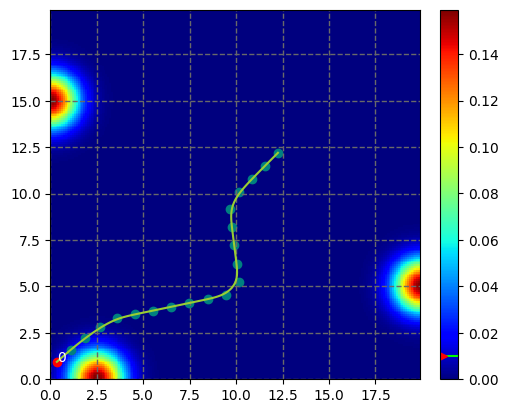

2


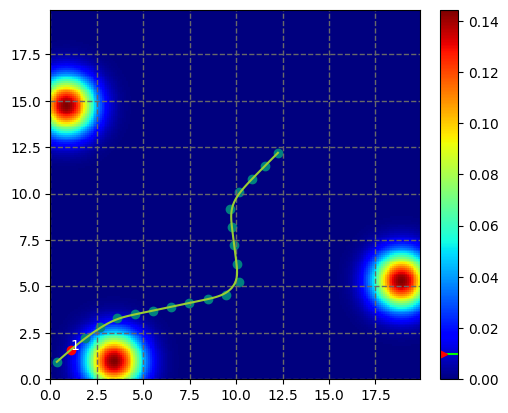

4


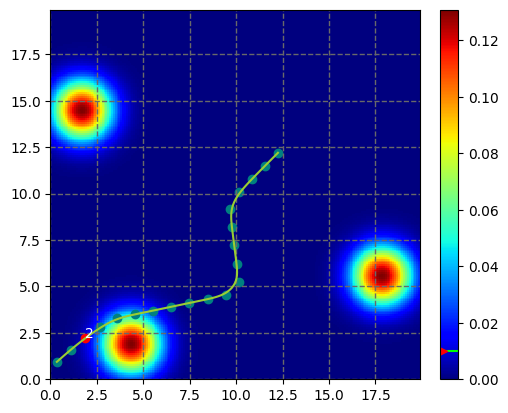

6


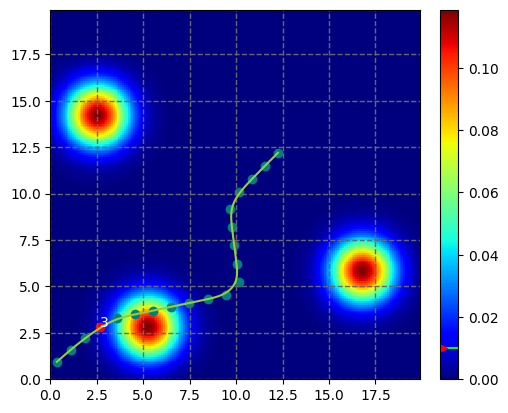

8


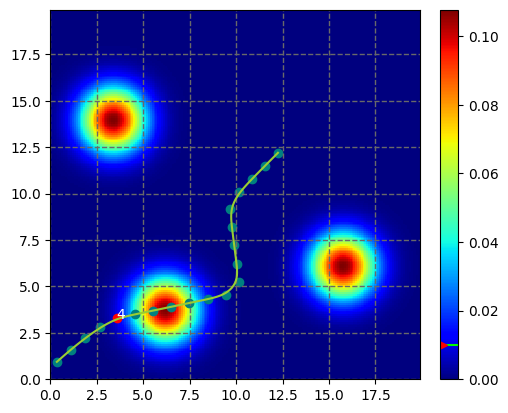

10


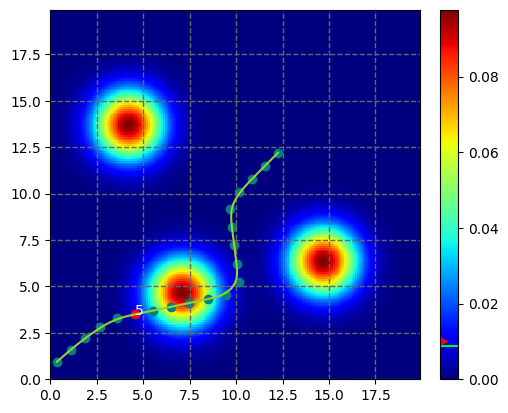

12


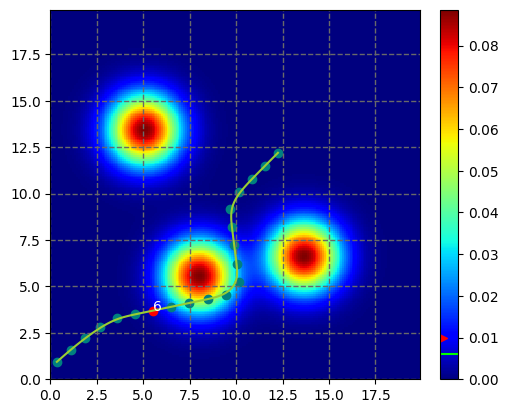

14


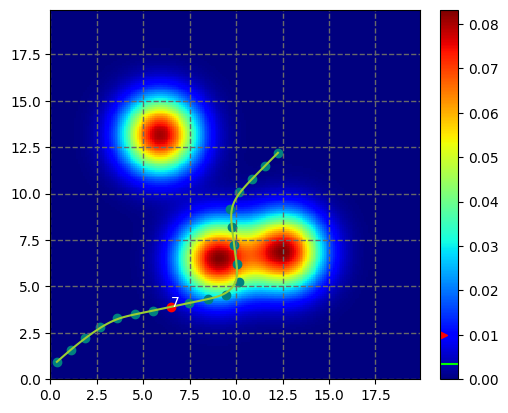

16


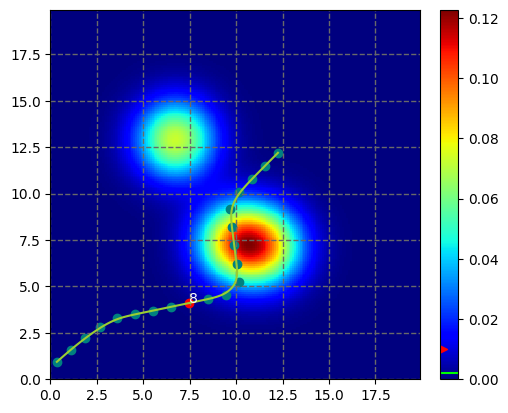

18


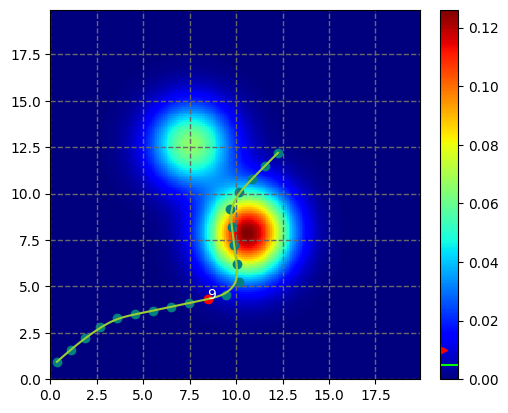

20


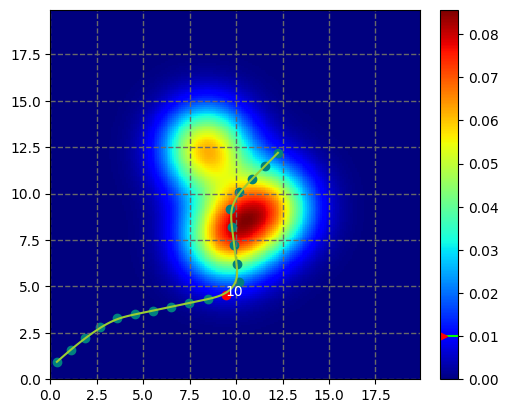

22


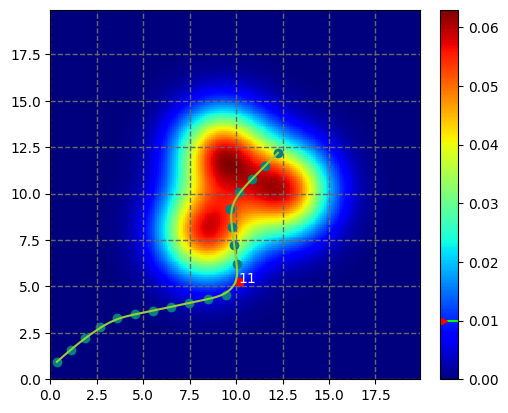

24


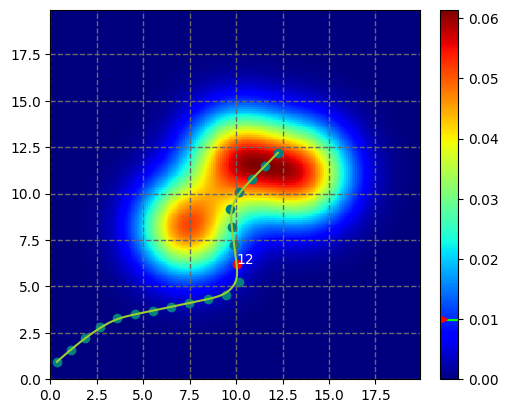

26


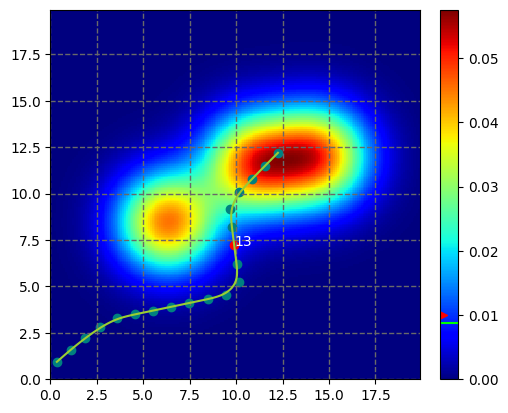

28


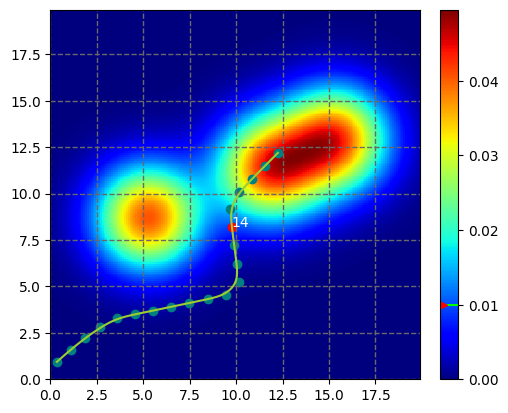

30


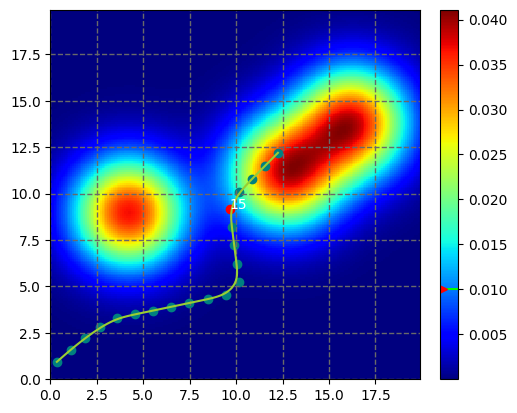

32


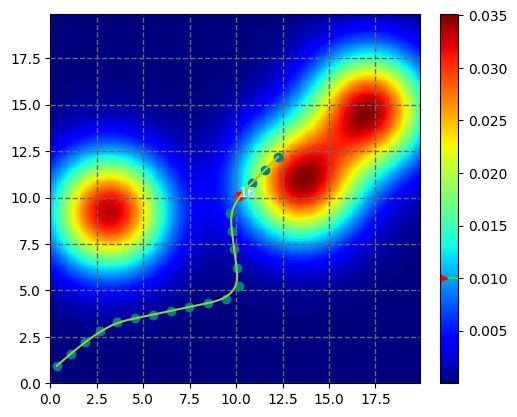

34


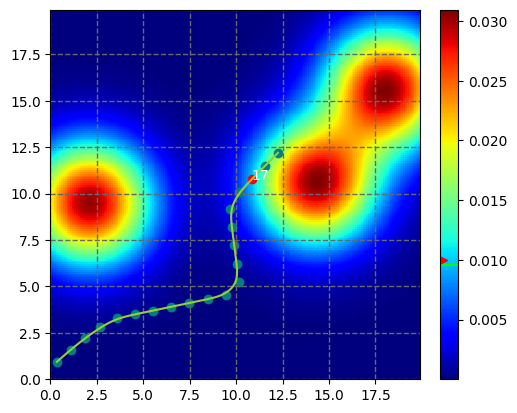

36


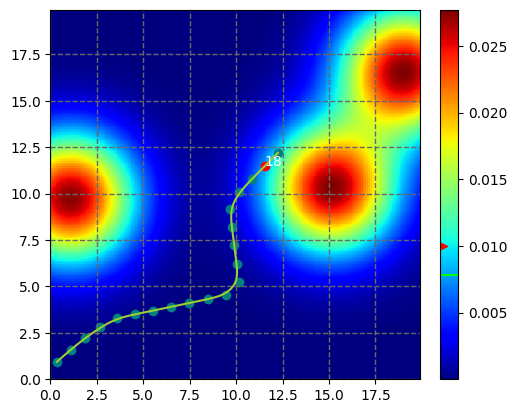

38


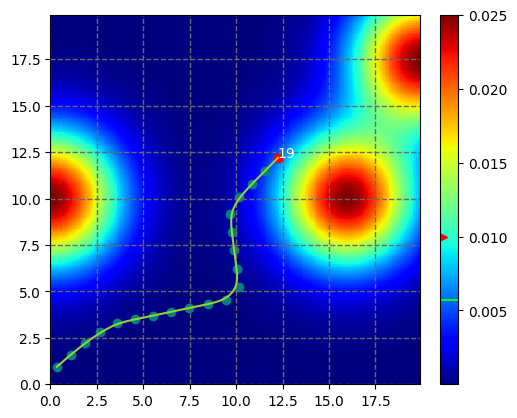

In [96]:
from geomdl import BSpline
from geomdl import utilities
from geomdl.visualization import VisMPL

# Create a B-Spline curve
curve = BSpline.Curve()
# Set up the curve
curve.degree = 4
frames = []
print(len(res.x))

for j in range(0, len(res.x), 2):
    cp = []
    print(j)
    G = 0
    out = 0
    for i in range(0, len(inturder_list)):
        G_tmp = gauss_function_2d([Xg, Yg], inturder_list[i][0][int(j/2)], inturder_list[i][1][int(j/2)], 1.05**(j/2), 1.05**(j/2))
        G = G + G_tmp
        
        gau = gauss_function_2d([res.x[j], res.x[j+1]], inturder_list[i][0][int(j/2)], inturder_list[i][1][int(j/2)], 1.05**(j/2), 1.05**(j/2))
        out = out + gau

    fig = figure()
    ax = fig.add_subplot(1,1,1)
    box = (x_.min(), x_.max(), y_.min(), y_.max())          # left, right, bottom, top
    im = ax.imshow(G, interpolation="none", origin='lower', extent=box, cmap='jet') #, vmin = 0, vmax = 0.15
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # draw a circle as a pointer on the colorbar's axes at value 0.5
    cbar.ax.scatter(0.0, out, s=1000, c='lime', marker="_")
    cbar.ax.scatter(0.0, probability_threshold, s=100, c='r', marker=">")

    ax.grid(color='dimgrey', linestyle='--', linewidth=1)
    # plt.ylabel('some numbers')
    for i in range(0, len(res.x), 2):
        # plt.scatter(res.x[i], res.x[i+1])
        cp.append([res.x[i], res.x[i+1]])
        if i == j:
            ax.annotate(int(i/2), (res.x[i], res.x[i+1]), color='w')
            plt.scatter(res.x[i], res.x[i+1], color='r')
        else:
            plt.scatter(res.x[i], res.x[i+1], color='teal')

    # plt.show()
    curve.ctrlpts = cp
    # Auto-generate knot vector
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
    # Set evaluation delta
    curve.delta = 0.01
    curvepts = np.array(curve.evalpts)
    curveplt, = plt.plot(curvepts[:, 0], curvepts[:, 1], color='yellowgreen', linestyle='-') 

    plt.savefig(f'./img/img_{j}.png')
    plt.show()
    plt.close()

In [ ]:
import imageio
frames = []
for t in range(0, len(res.x), 2):
    image = imageio.v2.imread(f'./img/img_{t}.png')
    frames.append(image)
# print(frames)
imageio.mimsave('./example_3in_t0.01_20cp_indicator.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # create some data
# vals = np.linspace(-np.pi/2, np.pi/2, 101)
# x, y = np.meshgrid(vals, vals)
# z = np.abs(np.sinc(x) * np.sinc(y))
# xDeg = np.rad2deg(x)
# yDeg = np.rad2deg(y)

# # plot the data
# plt.pcolormesh(xDeg, yDeg, z)

# # create a colorbar
# cbar = plt.colorbar()

# # draw a circle as a pointer on the colorbar's axes at value 0.5
# cbar.ax.scatter(0.5, 0.5, s=1000, c='r', marker='o')

# # show the plot
# plt.show()